In [ ]:
!nvidia-smi

Mon Oct  2 06:11:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -Uqqq pip --progress-bar off
!pip install -qqq torch==2.0.1 --progress-bar off
!pip install -qqq transformers==4.31.0 --progress-bar off
!pip install -qqq langchain==0.0.266 --progress-bar off
!pip install -qqq chromadb==0.4.5 --progress-bar off
!pip install -qqq pypdf==3.15.0 --progress-bar off
!pip install -qqq xformers==0.0.20 --progress-bar off
!pip install -qqq sentence_transformers==2.2.2 --progress-bar off
!pip install -qqq InstructorEmbedding==1.0.1 --progress-bar off
!pip install -qqq pdf2image==1.16.3 --progress-bar off

  Preparing metadata (setup.py) ... done


In [ ]:
!wget -q https://github.com/PanQiWei/AutoGPTQ/releases/download/v0.4.1/auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl

In [ ]:
!pip install -qqq auto_gptq-0.4.1+cu118-cp310-cp310-linux_x86_64.whl --progress-bar off

In [ ]:
!sudo apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.2 [186 kB]
Fetched 186 kB in 1s (212 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package poppler-utils.
(Reading database ... 120895 

In [ ]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
!mkdir pdfs

mkdir: cannot create directory ‘pdfs’: File exists


In [ ]:
# !gdown 1C720MEZxR7a6oj3sEFPnwq4p6ktdkfe2_ -O pdfs/fundamental.pdf
!gdown 151G_LaFAZX-1Sx7ZoHv9Z6lEvc8_dj6c -O pdfs/fundamental.pdf

Downloading...
From: https://drive.google.com/uc?id=151G_LaFAZX-1Sx7ZoHv9Z6lEvc8_dj6c
To: /content/pdfs/fundamental.pdf
100% 2.08M/2.08M [00:00<00:00, 207MB/s]


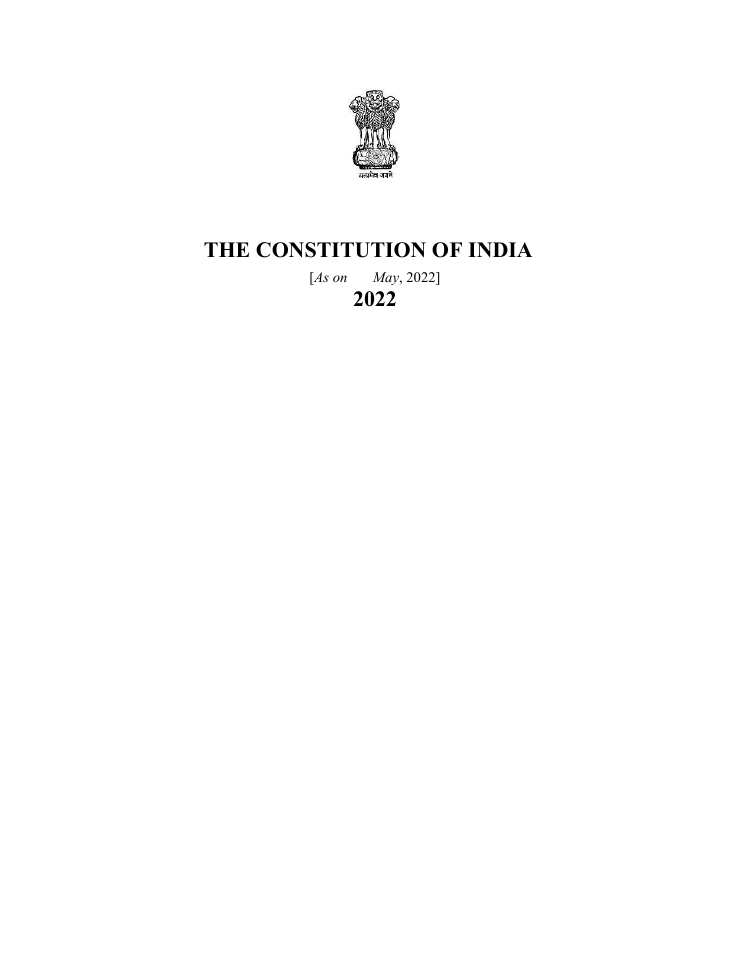

In [ ]:
meta_images = convert_from_path("pdfs/fundamental.pdf", dpi=88)
meta_images[0]

In [ ]:
!rm -rf "db"

In [ ]:
loader = PyPDFDirectoryLoader("pdfs")
docs = loader.load()
len(docs)

404

In [ ]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts = text_splitter.split_documents(docs)
len(texts)

1096

In [ ]:
%%time
db = Chroma.from_documents(texts, embeddings, persist_directory="db")

CPU times: user 1min 7s, sys: 2.11 s, total: 1min 9s
Wall time: 1min 33s


In [ ]:

model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

In [ ]:

!nvidia-smi

Mon Oct  2 04:38:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P0    36W /  70W |   9661MiB / 15360MiB |     92%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:

DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

In [ ]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)


In [ ]:

text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PLBartForCausalLM', 'ProphetNetForCausalLM', 'QDQBertLMHeadModel', 'ReformerModelWithLMHead', 'RemBertForCausal

In [ ]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})


In [ ]:

SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

In [ ]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

In [ ]:
result = qa_chain("What is fundamental rights?")

 Based on the given text, fundamental rights refer to the basic rights and freedoms guaranteed to all citizens of India by the Constitution. These rights include the right to freedom of speech and expression, the right to assemble peacefully, the right to form associations, the right to move freely throughout the territory of India, the right to reside and settle in any part of the territory, the right to practice any profession or carry on any occupation, trade or business, and the right to equality before the law. These rights are protected by the Constitution and cannot be taken away or abridged by the state except in cases where it is necessary to do so in the interest of public order, morality, or the general welfare of the country.


In [ ]:
len(result["source_documents"])

2

In [ ]:
print(result["source_documents"][0].page_content)

THE CONSTITUTION OF INDIA
(Part III. —Fundamental Rights. —Arts.  18-19.)9
(3) No person who is not a citizen of India shall,
while he holds any office of profit or trust under the
State, accept without the consent of the President any
title from any foreign State.
(4)  No person holding any office of profit or trust
under the State shall, without the consent of the President,accept any present, emolument, or office of any kindfrom or under any foreign State.
Right to Freedom
19. (1) All citizens shall have the right—
(a) to freedom of speech and expression;
(b) to assemble peaceably and without arms;
(c) to form associations or unions;
(d) to move freely throughout the territory of India;
(e) to reside and settle in any part of the territory
of India;  
1[and]
       2*                       *                      *                      *                      *
(g) to practise any profession, or to carry on any
occupation, trade or business.
3[(2) Nothing in sub-clause ( a) of clause 

In [ ]:
result = qa_chain("What is the per share revenue for Tesla during 2023?")

 I cannot provide information about the current year's revenue for Tesla or any other company. The text provided does not contain any information about Tesla's revenue in 2023 or any other specific year. Additionally, the text is related to the Indian Constitution and its articles, which are not relevant to Tesla's financial performance. Therefore, I do not have enough information to provide an answer to your question.


In [ ]:
result = qa_chain("can a 14 year old be employed legally?")

 Based on the Indian Constitution, it is not legal for a 14-year-old to be employed. According to Article 24 of the Constitution, "No child below the age of fourteen years shall be employed to work in any factory or mine or engaged in any other hazardous employment." This means that it is illegal to employ anyone under the age of 14 in any job, including factories and mines. Additionally, the Constitution guarantees the right to education for all children between the ages of 6 and 14, which suggests that children should be in school rather than working. Therefore, it is unlikely that a 14-year-old could be employed legally in India.


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install -qqq streamlit --progress-bar off

In [ ]:
%%writefile app.py
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"


model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)


DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <>
{system_prompt}
<>

{prompt} [/INST]
""".strip()

streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)


text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    temperature=0,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0})


SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}
""",
    system_prompt=SYSTEM_PROMPT,
)

prompt = PromptTemplate(template=template, input_variables=["context", "question"])


qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

def main():
    st.title("LAWGPT 📄")
    with st.expander("About the App"):
        st.markdown(
            """
            This is a Generative AI powered Question and Answering app that responds to questions about your PDF File.
            """
        )
    question = st.text_area("Enter your Question")
    if st.button("Ask"):
        st.info("Your Question: " + question)

        st.info("Your Answer")
        answer = qa_chain(question)
        st.write(answer)
        # st.write(metadata)


if __name__ == '__main__':
    main()



Writing app.py


In [ ]:
!pip install fastapi
!pip install uvicorn
!pip install pickle5
!pip install pydantic
!pip install requests
!pip install pypi-json
!pip install pyngrok
!pip install nest-asyncio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.1/132.1 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pickle5: filename=pickle5-0.0.11-cp310-cp310-linux_x86_64.whl size=255318 sha256=74db5a29dd832fb0964debbaf7414c7866e65d526e583c293b94822f256a387e
  Stored in directory: /root/.cache/pip/wheels/7d/14/ef/4aab19d27fa8e58772be5c71c16add0426acf9e1f64353235c
Successfully built pickle5
  Obtaining dependency information for pypi-json from https://files.pythonhosted.org/packages/0b/0c/246389572f52cba2c736be8c646f2f868f1b9458a8e6d5fc675656b3e01b/pypi_json-0.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for apeye>=1.1.0 from https://files.pythonhosted.org/packages/89/7b/2d63664777b3e831ac1b1d8df5bbf0b7c8bee48e57115896080890527b1b/apeye-1.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for apeye-core>=1.0.0b2 from https://files.pythonhosted.org/packages/f4/af/7cfe2c5e01d70848ac1731c8ab37e0e49ab39cf18e595446c192349639c0/ap

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import pickle
import json
import uvicorn
from pyngrok import ngrok
from fastapi.middleware.cors import CORSMiddleware
import nest_asyncio

In [ ]:
app = FastAPI()

In [ ]:
origins = ["*"]

app.add_middleware(
    CORSMiddleware,
    allow_origins=origins,
    allow_credentials=True,
    allow_methods=["*"],
    allow_headers=["*"],
)

In [ ]:
@app.post('/')
def gpt_res(input_parameters : model_input):

    input_data = input_parameters.json()
    input_dictionary = json.loads(input_data)

    return 'The person is diabetic'

NameError: ignored

In [ ]:
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)